# Climate Model Package Tutorial

Climate science has experienced a large growth in interest over the past several decades, especially with regards to changing climate trends like temperature, weather patterns, and sea levels. This package allows the user to do parameter estimation and model comparison using Bayesian inference. While only a few models are supported in the package, the user is capable of modifying the source code to add new models with minimal effort.

## Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data IO and modeling packages:

In [2]:
# Modules for climate model analysis
from climate import data_io
from climate.inference import model
from climate.pySCM.SimpleClimateModel_opt import *

## Example data

The data against which we compare our model is a timeseries of global **temperature anomaly** averages. Begin by calling `get_example_data_file_path`, which takes as input the name of the file and the location of the data file (the `data/` directory is the default) and returns the location of the file.

In [3]:
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')

Now we call `load_data_temp`, which takes the file location as input and returns a Pandas data frame containing temperature data. Note that this function's behavior is specific to the format of the text file for temperature data obtained from the Berkeley group.

In [4]:
# Load data and obtain numpy arrays for data and uncertainty
data = data_io.load_data_temp(fileload)
year = data['year'].values
temperature = data['monthly_anomaly'].values
tempUnc = data['monthly_anomaly_unc'].values

We'll be comparing these actual data to a simple climate model which takes as input several timeseries of greenhouse gas emissions.  The emissions data are provided at yearly intervals, and the predicted temperature anomaly from the simple climate model is given at the same years spanned by the emissions data.  The temperature anomaly data that we imported above, however, is provided at monthly intervals.  To ensure that the temperature data and model predictions have the same temporal resolution, we will compute yearly averages and uncertainties (by adding in quadrature):

In [5]:
# Temperature data are recorded at monthly intervals, but we will 
# compute yearly averages and uncertainties to match the (yearly) 
# resolution of the emissions files
year = (data['year'].values)[0::12]

#temperature = temperature[0::12]
temperature = data.groupby('year').mean()['monthly_anomaly'].values

# Uncertainties in the data files correspond to 95% CL (2-sigma), 
# divide these values by 2 to obtain 68% CL (1-sigma)
tempUnc = data['monthly_anomaly_unc'].values / 2

# tempUnc has length 2018, so we will pad with zeros to get something with
# a length that is divisible by 12, which will make it easier to compute the 
# propagated error uncertainty for each year
tempUnc = np.append(tempUnc,[0,0,0,0,0,0,0,0,0,0])
tempUnc = tempUnc.reshape(169,12)
tempUnc = np.array([data_io.add_in_quad(errs) for errs in tempUnc])

In [6]:
# Load in emissions data
fileload = get_example_data_file_path('EmissionsForSCM.dat', data_dir='pySCM')
ems = load_data_emissions(fileload)

Now we will plot the temperature anomaly and errorbars obtained from the data file:

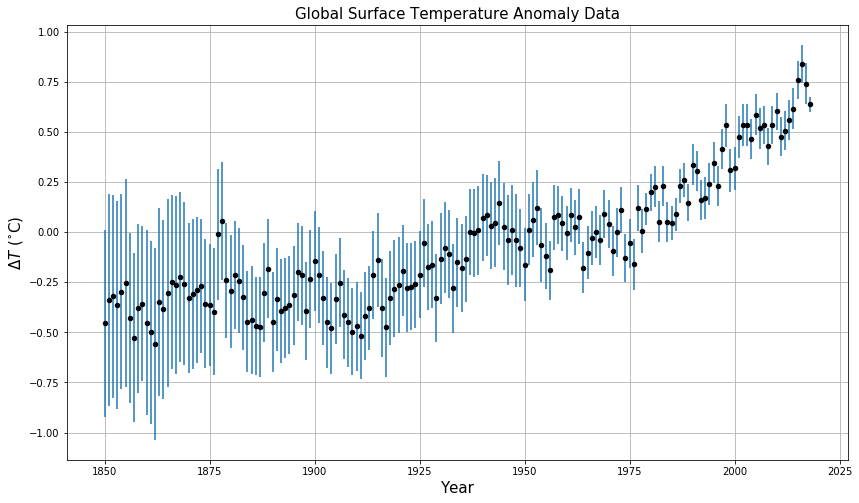

In [7]:
# We can plot temperature anomaly vs. time
plt.figure(figsize=(14,8))
plt.errorbar(year, temperature, tempUnc, linestyle='none')
plt.scatter(year, temperature, c='k', zorder=5, s=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('$\Delta T$ ($^{\circ}$C)', fontsize=15)
plt.title('Global Surface Temperature Anomaly Data', fontsize=15);
plt.grid()

Now that the data is imported, we can do parameter estimation on a model. We use the package `pySCM`, which is a simple model for temperature change that uses emissions curves for 4 green house gases. We use a modified version of this model with a large number of parameters: overall temperature shift (to exchange between temperature change and anomoly), and parameter for each of the emissions curves data points, which are ultimately marginalized out. This model is called `ModifiedSimpleClimateModel`. The user can create an instance of this model and offer the data as input to the constructor:

In [ ]:
# Create Modified Simple Climate Model instance
SCM = model.ModifiedSimpleClimateModel(year, temperature, tempUnc)

Next, the user should set the priors on the model parameters. Each instance of `Model` (superclass of `ModifiedSimpleClimateModel`) has as a field an array of `ndim` instances of `Prior`, each of which can be called once initialized. To see this in action, we initialize the model priors by giving it an array of length `ndim` containing strings of the prior type (uniform, Guassian, Jeffreys, Poisson, or exponential decay) and two arrays containing the 2 parameters of the prior. In the case of a prior that only takes a single parameter, a placeholder can be used for the second parameter.

In [ ]:
# Set prior types on parameters; temperature shift and gas points
shift_prior_type = ['uniform']
ems_prior_type = ['gaussian' for i in range(4*len(ems['CO2']))]
prior_type = shift_prior_type + ems_prior_type

# Set first prior parameters
prior_shift_param1 = [-1.0]
prior_ems_param1 = [el for v in ems for el in ems[v]]
prior_param1 = prior_shift_param1 + prior_ems_param1

# Set second prior parameters
prior_shift_param2 = [ 1.0]
gas_uncertainties = [0.18, 1., 1., 0.3] # CO2, CH4, N2O ,SOx
#gas_uncertainties = [0.05, 0.05, 0.05, 0.05] # CO2, CH4, N2O ,SOx
prior_ems_param2 = [gas_uncertainties[i]*(el+1e-2) for i,v in enumerate(ems) for el in ems[v]]
prior_param2 = prior_shift_param2 + prior_ems_param2
SCM.set_priors(prior_type, prior_param1, prior_param2)

Now we can call each of these priors and check that they give the expected distribution. To obtain a particular prior (which can be called as a function), call `SCM.priors`, which is an array, so `SCM.priors[i]` is the prior of the $i^\text{th}$ parameter of the model:

In [ ]:
# Test that priors are working as expected
test_x = np.linspace(-1.5, 1.5, 500)
test_prior1 = [ np.exp(SCM.priors[0](tx)) for tx in test_x ]
test_prior2 = [ np.exp(SCM.priors[5](tx)) for tx in test_x ]
plt.plot(test_x, test_prior1)
plt.plot(test_x, test_prior2)

Note that these distributions are normalized to unity.

Now that the model and its priors are initialized, we can run a Markov-Chain Monte Carlo algorithm implemented by the package `emcee`. To do this, create an array of initial guesses of the model parameters. Then call `run_MCMC` with this array, the number of walkers to use, and the number of steps for each walker:

In [ ]:
# Run MCMC on the model
paramGuess = ([-0.35]  + list(ems['CO2'])
                      + list(ems['N2O'])
                      + list(ems['CH4'])
                      + list(ems['SOx']))
%time SCMsample = SCM.run_MCMC(paramGuess, nwalkers=2*SCM.ndim, nsteps=10)

The user can then call `show_results` on the model with the number of initial steps to skip (burn-in). The function displays a histogram and kernel-density for each of the parameters (marginalized over all others) as well as traces for the values that each of the walkers takes over the course of the routine. The data and best-fit for the model are plotted together. The best-fit values reported are the medians and the intervals are the 16$^\text{th}$ and 84$^\text{th}$ percentiles.

In [ ]:
# Plot results from the sampling
SCM.show_results(burnin=0, params_to_plot=[0])

We also have a class `BasicCloudSeedingModel`, which is a 2-parameter model for cloud seeding based off of solar activity data. It takes the following functional form:
$$ \Delta T_i = \alpha \times  a_{\rm sun}(t-t_{lag}), $$
where $\alpha$ is a normalization constant, $t_{\rm lag}$ is the time lag between the seeding of clouds and the impact on temperature, and $a_{\rm sun}$ is a Gaussian Process Regression (GPR) that is fit to the solar data.

In particular, we use sunspot number as the input for our model. The GPR is used to interpolate between data points so that a greater resolution on $t_{lag}$ can be obtained. Again, we use `data_io` to read in the data in the same fashion as before and generate a plot of the data:

In [7]:
# Cloud Seeding Model, plot of flare data
fileload = data_io.get_example_data_file_path(
    'SN_y_tot_V2.0.txt', data_dir='data/sunspots')
data_sunspots = data_io.load_data_y_sunspot(fileload)

In [8]:
# We will focus on times from 1818 onwards (uncertainties not present earlier)
# Additionally, the yearly averages are centered at the middle of each year, 
# but in our convention with the temperature data, we take the floor of this number
years_sunspots = np.floor(data_sunspots['year'].values[118::])
sunspots = data_sunspots['yearly_sunspot_number'].values[118::]
sunspots_unc = data_sunspots['stdev'].values[118::]

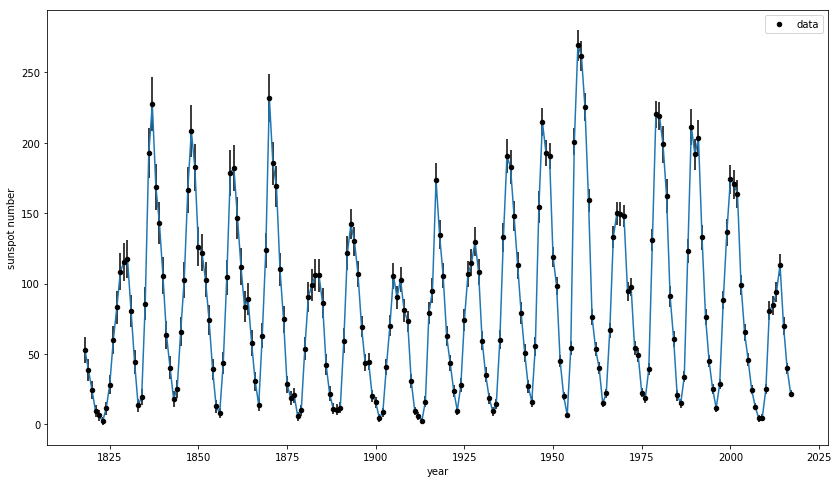

In [9]:
#Plot the data
plt.figure(figsize=(14,8))
plt.plot(years_sunspots, sunspots, color='C0')
plt.errorbar(years_sunspots, sunspots, sunspots_unc,  linestyle='none',color='k')
plt.scatter(years_sunspots, sunspots, color='k', zorder=5, s=20, label='data')
plt.legend()
plt.xlabel('year')
plt.ylabel('sunspot number');

Using these sunspot data, let's create an instance of <code>BasicCloudSeedingModel</code> from the <code>model</code> package; it takes as input the temperature data (first three parameter fields), the solar data (next three parameters), and the factor of time resolution increase obtained from the GPR. The GPR is produced with the desired resolution and is plotted over the data in the beginning. The </code>BasicCloudSeedingModel</code> sets the hyperpriors for the GPR and runs an MCMC when it is first intitialized:

Running MCMC on GPR of Solar Data


/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Progress: 
[####################################################################################################]

Generating Point Estimate of Gaussian Process Regression
Progress: 
[####################################################################################################]



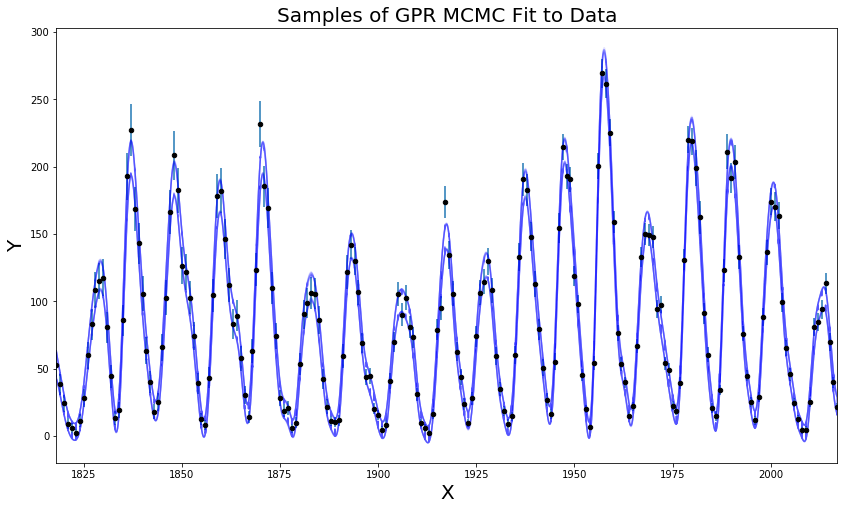

In [10]:
# Test Cloud Seeding Model
CSModel = model.BasicCloudSeedingModel(year, temperature, tempUnc, years_sunspots, sunspots, sunspots_unc, 100)

As described above, the cloud seeding model has two parameters, $\alpha$ and $t_{\rm lag}$, so we set priors for these parameters as before:

In [ ]:
# Set priors on parameters
prior_type = ['uniform', 'exponentialdecay' ]
prior_param1 = [-0.5, 0.5]
prior_param2 = [ 0.5, -1]
CSModel.set_priors(prior_type, prior_param1, prior_param2)

What if ALL variation in global temperature were a result of cloud seeding?  This is unreasonable, but we can still assume this is the case and compute best-fit parameters:  

In [ ]:
# Run MCMC on the cloud seeding model
paramGuess = [0.05, 0.5]
%time CSModelSample = CSModel.run_MCMC(paramGuess, nwalkers=50, nsteps=500)

In [ ]:
# Plot results from the sampling
CSModel.show_results(burnin=0, params_to_plot=[0,1])

So far, we've defined a simple climate model, and also a basical cloud seeding model.  We can use the <code>CombinedModel</code> class to merge the two models, and perform parameter estimation on the models. To do this, we again make arrays for the priors, create an instance of `CombinedModel` that takes as input the models to combine, and then we call `set_priors` as before:

In [ ]:
# Set prior types on parameters
shift_prior_type = ['uniform']
ems_prior_type = ['gaussian' for i in range(4*len(ems['CO2']))]
alph_prior_type = ['uniform']
tlag_prior_type = ['uniform']
prior_type = shift_prior_type + ems_prior_type + alph_prior_type + tlag_prior_type

# Set first prior parameters
prior_shift_param1 = [-1.0]
prior_ems_param1 = [el for v in ems for el in ems[v]]
prior_alph_param1 = [-0.1]
prior_tlag_param1 = [0]
prior_param1 = (prior_shift_param1 
                + prior_ems_param1 
                + prior_alph_param1 
                + prior_tlag_param1)

# Set second prior parameters
prior_shift_param2 = [0]
gas_uncertainties = [0.18, 1., 1., 0.3] # CO2, CH4, N2O ,SOx
prior_ems_param2 = [gas_uncertainties[i]*(el+1e-3) 
                    for i,v in enumerate(ems) for el in ems[v]]
prior_alph_param2 = [0.1]
prior_tlag_param2 = [0.5]
prior_param2 = (prior_shift_param2 
                + prior_ems_param2
                + prior_alph_param2
                + prior_tlag_param2)
SCM.set_priors(prior_type, prior_param1, prior_param2)

# Construct combined model
CombinedClimateModel = model.CombinedModel(SCM, CSModel)
CombinedClimateModel.set_priors(prior_type, prior_param1, prior_param2)

We then call `run_MCMC` on the combined model as before:

In [ ]:
# Run MCMC on combined model
paramGuess = ([-0.325]  + list(ems['CO2'])
                      + list(ems['N2O'])
                      + list(ems['CH4'])
                      + list(ems['SOx'])
                      + [0.01] + [0.1])
%time combined_model_sample = CombinedClimateModel.run_MCMC(paramGuess,nwalkers=2*CombinedClimateModel.ndim, nsteps=600)

And as before, we can show the results of the algorithm using `show_results`:

In [ ]:
# Show the results of the MCMC algorithm
CombinedClimateModel.show_results(burnin=0,params_to_plot=[0,677,678])

# Generative model and Likelihood Function

Both the SCM and cloud seeding models are deterministic. There are two sources of uncertainties in our case - random noise in temperature measurement, and a model uncertainty originating from the uncertainty of solar data (the independent variable).

We use Gaussian models for both the random noise of temperature anomaly measurement and uncertainty of solar data, with one-sigma standard deviation being the widths of the Gaussians. This is because when we have no better information about the distribution of the errors except its width/spread, a Gaussian is the least commital (maximum entropy) choice, which avoids underestimating the uncertainty in the posterior.

The model uncertainty is
$$\sigma_{z_t} = |dz/da_{{\rm sun}}| \sigma_{{\rm sun},t-t_{\rm lag}} = |\alpha| \sigma_{{\rm sun},t-t_{\rm lag}},$$ where $z_t$ is the model prediction at time t, and $\sigma_{{\rm sun},t-t_{\rm lag}}$ is the uncertainty of the sunspot data at an earlier time $t-t_{\rm lag}$.
Thus we have
$$P(Z_t|\theta, M)=  f_Z(z_t)= \frac{1}{\sqrt{2 \pi \alpha^2 \sigma_{\rm sun,t-t_{\rm lag}}^2}}
 \exp \left( \frac{-(z_{t}- \alpha a_{{\rm sun},t-t_{\rm lag}})^2}{2 \alpha^2 \sigma_{{\rm sun},t-t_{\rm lag}}^2}\right).$$
The random error of temperature measurement is
$$P(E_t|\theta, M)=  f_E(y_t-z_t)= \frac{1}{\sqrt{2 \pi \sigma_{t}^2}}
 \exp\left(\frac{-e_{t}^2}{2 \sigma_{t}^2}\right),$$ where $y_t$ is the measured value of temperature anomaly at time t and $\sigma_{t}$ is the random noise in temperature measurement.
The two sources of uncertainty are independent.
Now $p(Y_t|\theta, M)$ is the convolution of $f_Z(z_t)$ and $f_E(y_t-z_t)$. In the case where both functions are Gaussians, the convolution yields a simple result for the data point at time t:
$$P(Y_t|\theta, M)=  \frac{1}{\sqrt{2 \pi (\sigma_{t}^2 + \alpha^2 \sigma_{\rm sun,t-t_{\rm lag}}^2)}}
 \exp\left(\frac{-(y_{t}- \alpha a_{{\rm sun},t-t_{\rm lag}})^2}{2 (\sigma_{t}^2 + \alpha^2 \sigma_{{\rm sun},t-t_{\rm lag}}^2)}\right).$$
Because the data points at different times are independent, the likelihood function is a product of $p(Y_t|\theta, M)$ for all times.